In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime

import pandas as pd
import scipy.stats as stats

## Investigating snow depth data from the SoS Kettle Ponds site

Snow depth at Kettle Ponds is calculated from six scanning lidars.  See the interview with Ethan Gutmann in Module 4 to hear more about how they work.  Here, Ethan has extracted timeseries of the snow depths at our four snow pillow locations (from Module 2), using each of the lidars.

In [3]:
start_date = datetime.datetime(2022, 10, 10)
end_date = datetime.datetime(2023, 3, 25)

Now we read in the data and plot it.

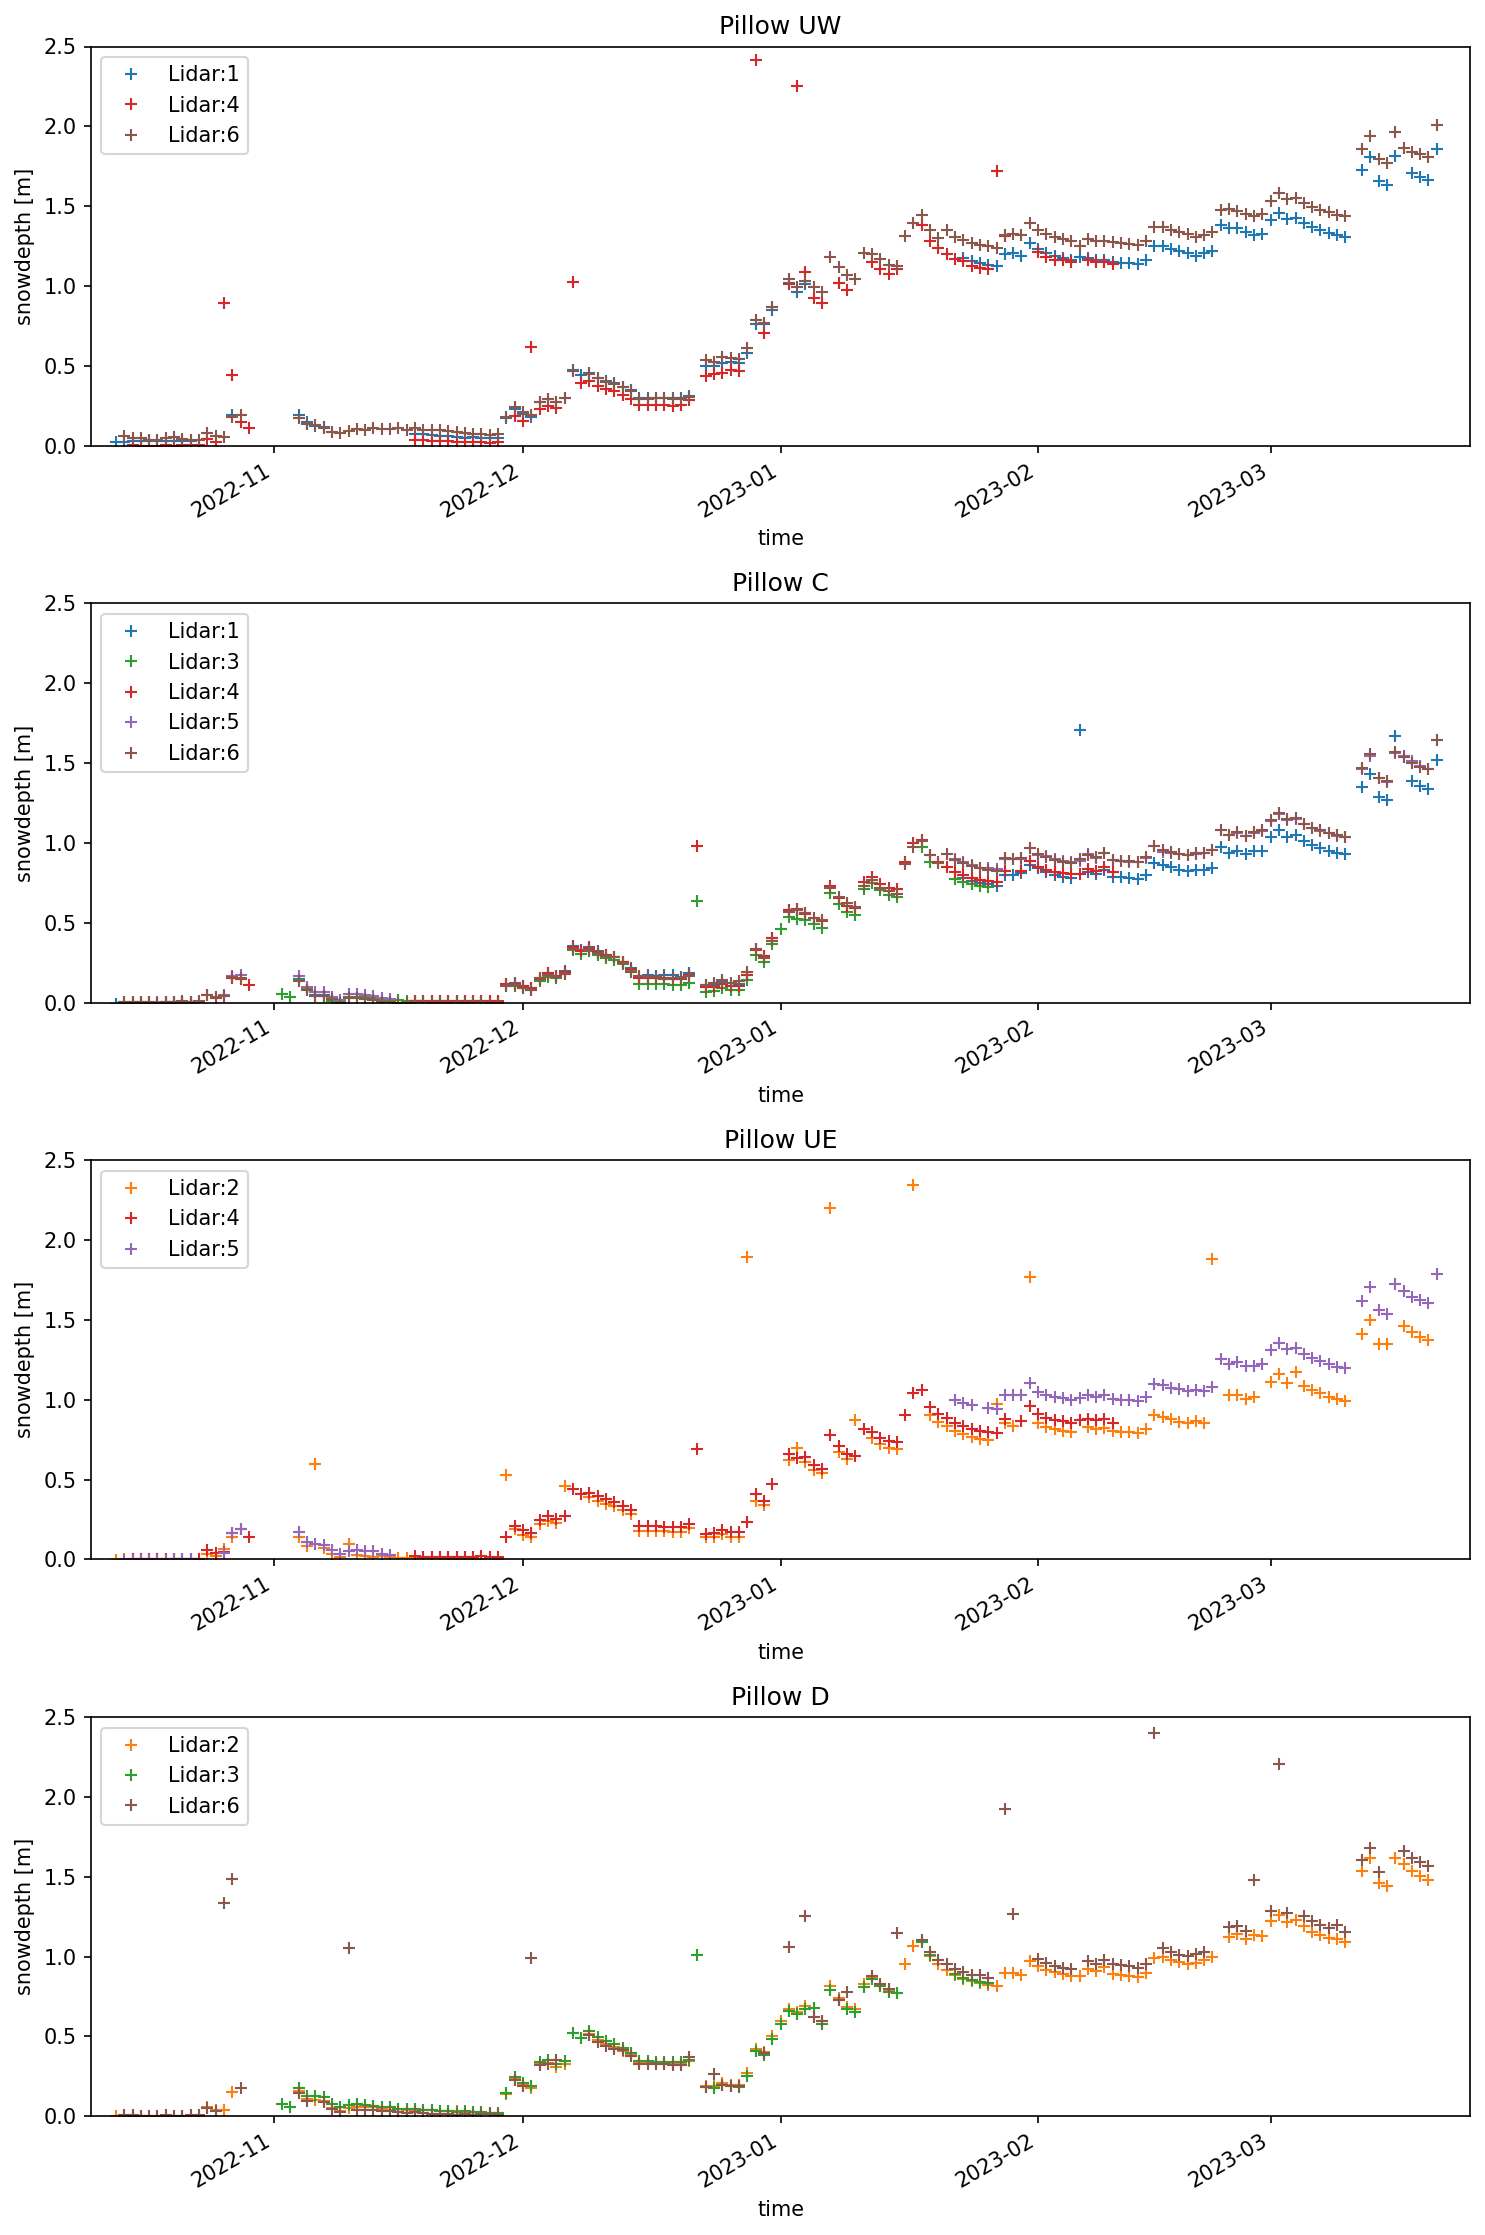

In [6]:
plt.figure(figsize=(10,15), dpi=150)

colors = [f"C{i}" for i in range(6)]
# i represents a different lidar that is observing the snow depth

pillow_list = ["UW","C","UE","D"]
# these designations indicate which snow pillow location we are measuring the depth at
# these locations, with labels, are indicated on the map shown in Module 2
# They stand for "UW = upwind west", "C = center", "UE = upwind east", and "D = downwind"

for i,p in enumerate(pillow_list):
    plt.subplot(4,1,i+1)

    for l in range(1,7):
        ds = xr.open_dataset(f"lidar_l{l}_pillow_depths.nc")
        try:
            if p in ds["pillow"]:
                s="mean"
                ds["snowdepth"].sel(stat=s,pillow=p).plot(marker='+', linestyle="", label=f"Lidar:{l}", color=colors[l-1])                
        except:
            print(f"Error with lidar {l} for pillow {p}")

    plt.ylim(0,2.5)
    plt.legend()
    plt.title(f"Pillow {p}")
    plt.xlim(start_date, end_date)
    
plt.tight_layout()

Above, we see how snow depth changes with time, and we also see how the lidar vary from each other.  Let's take a moment to investigate what is in this dataset.  We look at lidar 4, which is mounted on the downwind tower and views the central and upwind snow pillows.

In [25]:
ds2 = xr.open_dataset('lidar_l2_pillow_depths.nc')
ds2

<xarray.Dataset>
Dimensions:    (time: 146, stat: 6, pillow: 2)
Coordinates:
  * time       (time) datetime64[ns] 2022-10-13 2022-10-14 ... 2023-03-20
  * stat       (stat) object 'mean' 'stddev' 'median' 'min' 'max' 'count'
  * pillow     (pillow) object 'UE' 'D'
Data variables:
    snowdepth  (time, stat, pillow) float64 ...

We see that at each point in time and at each snow pillow, there are a collection of lidar returns over the snow pillow location.  These have summary statistics given by the "stat" attribute, including the mean, standard deviation, minimum, maximum, and count of return.  We can use these to assess which measurements to trust best.  Below, we plot these statistics for each lidar and pillow.

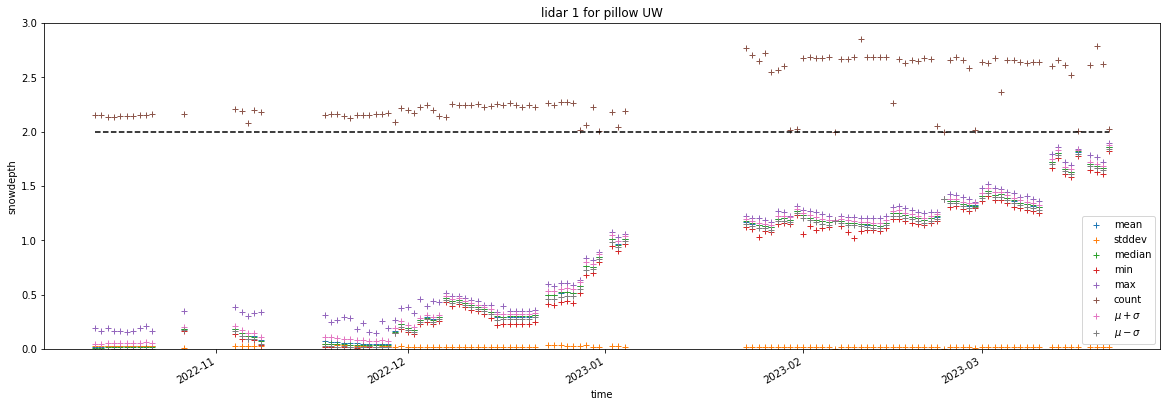

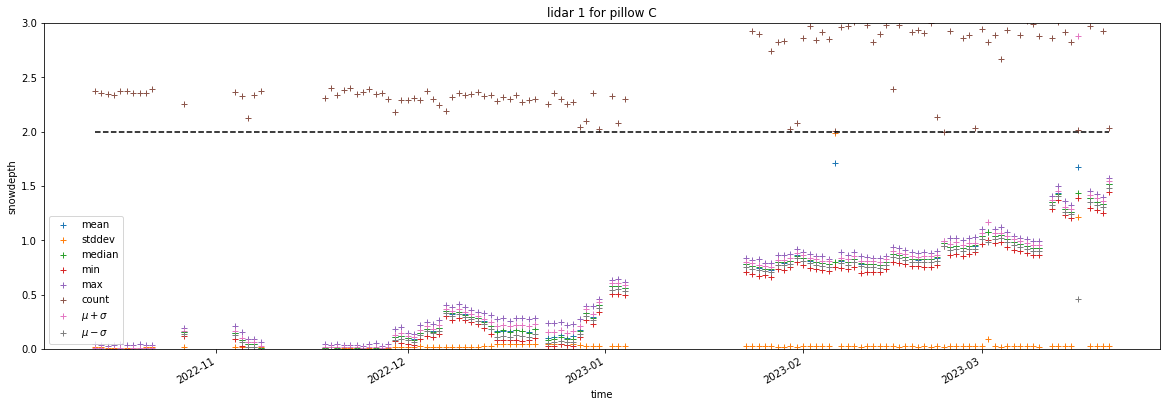

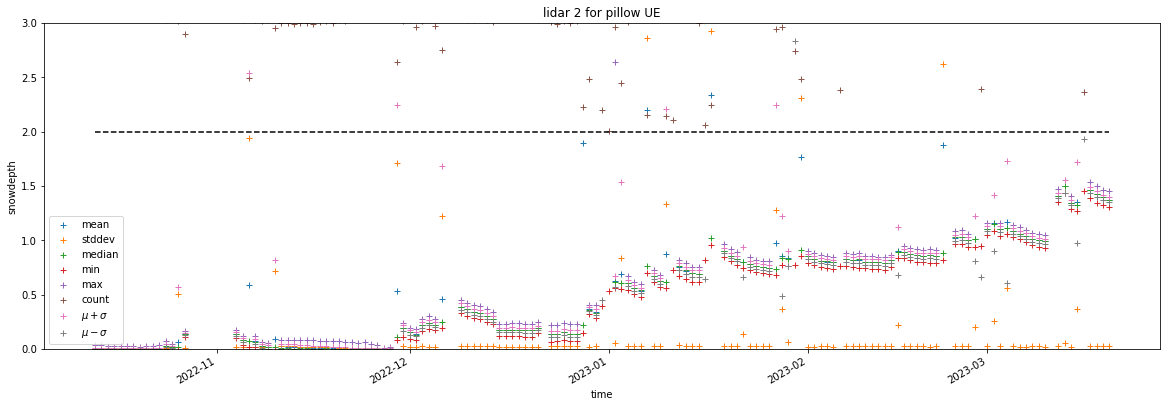

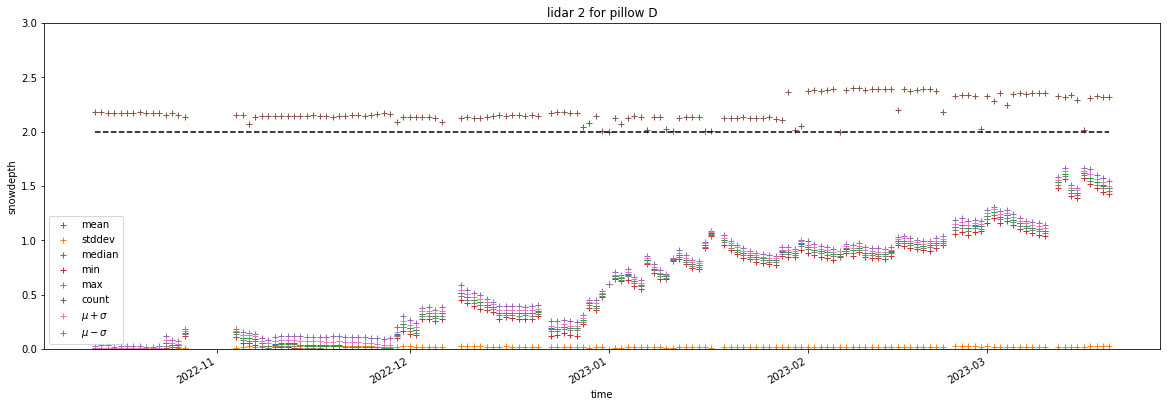

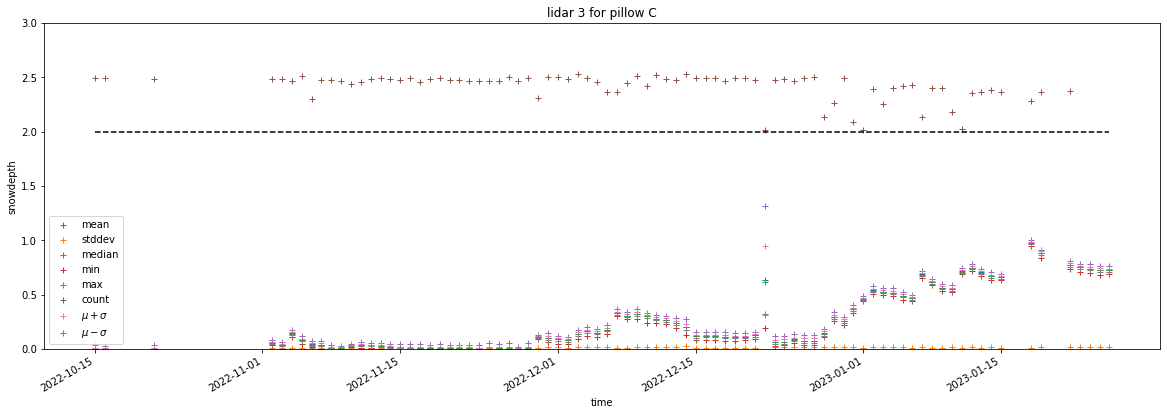

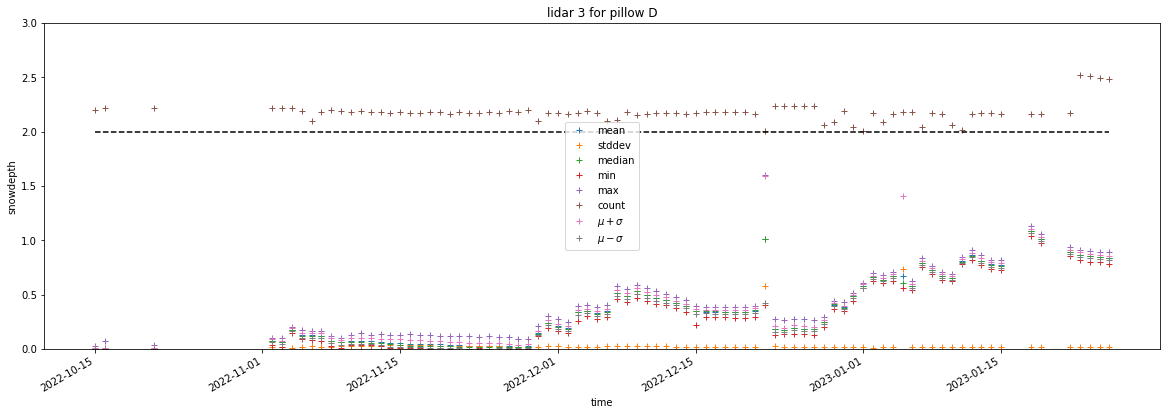

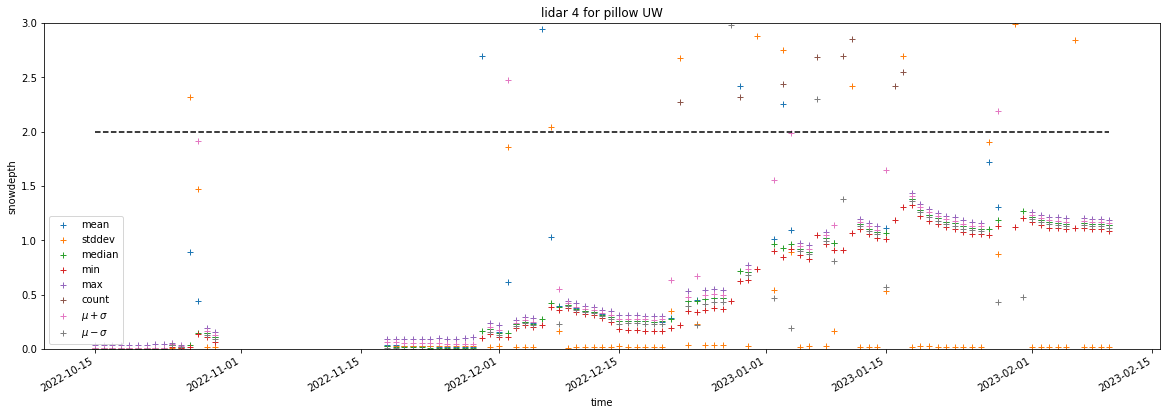

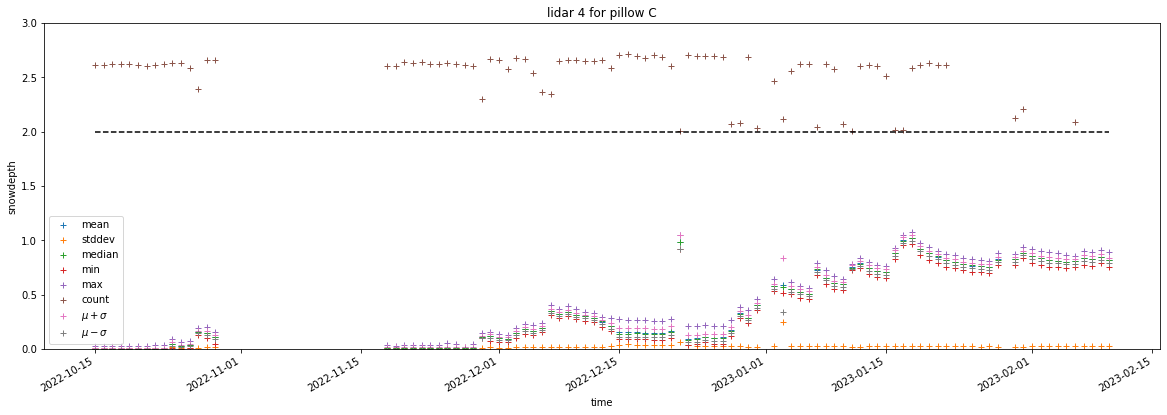

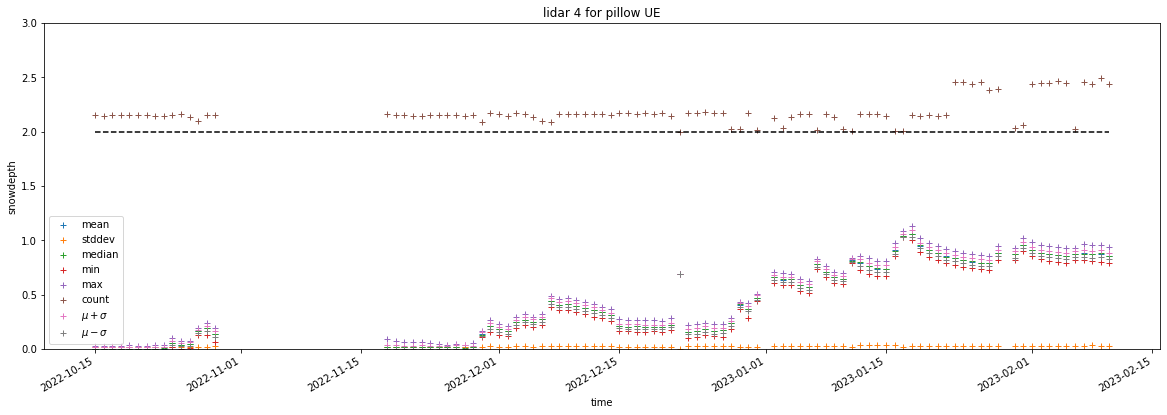

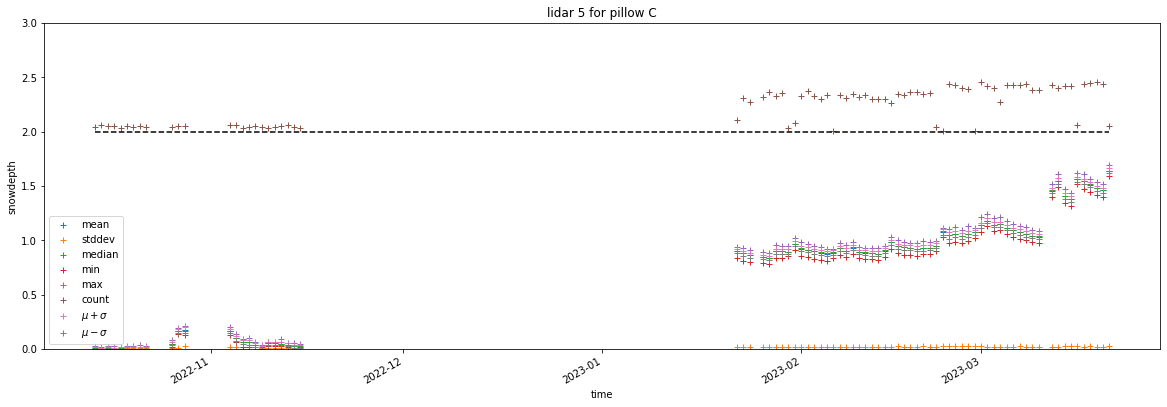

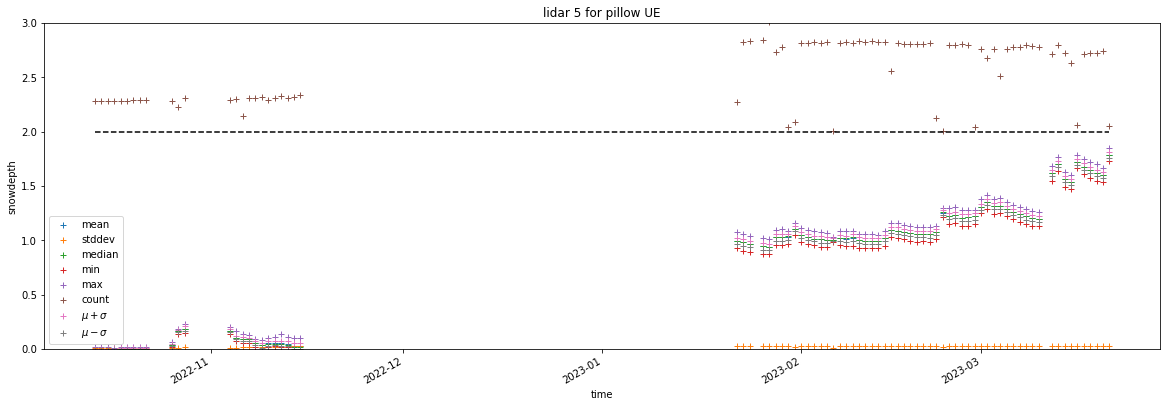

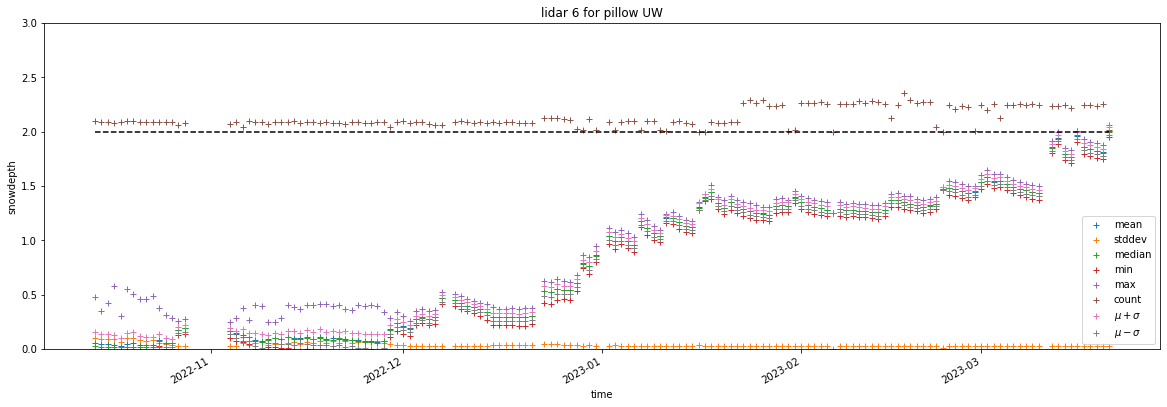

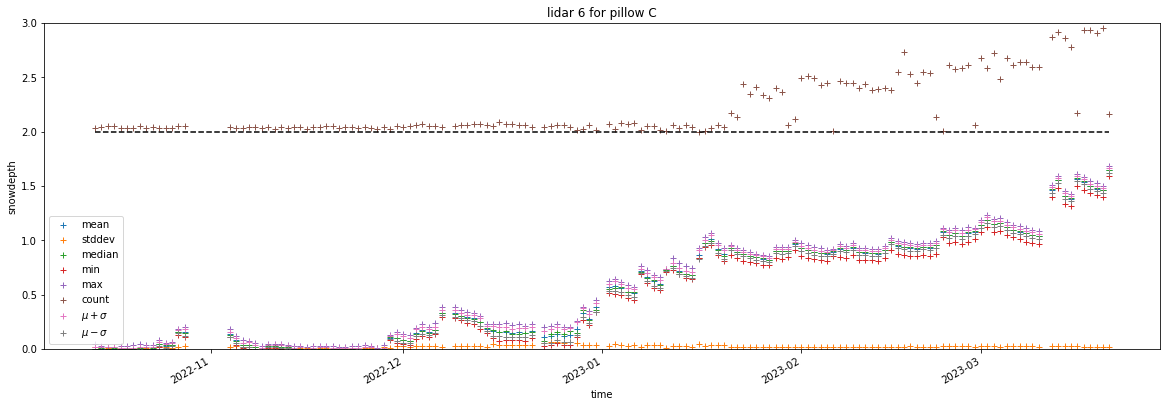

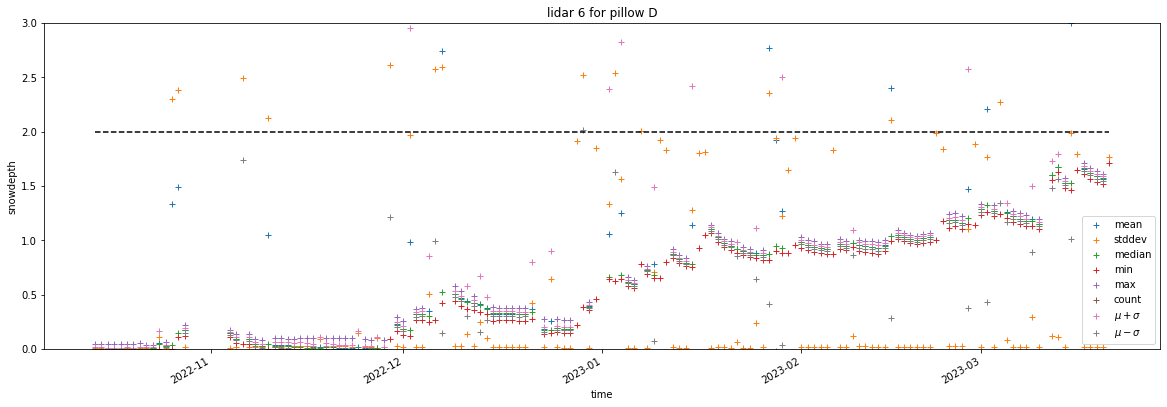

In [11]:
# Plot lidar snow depth statistics
for l in range(1,7):
    ds = xr.open_dataset(f"lidar_l{l}_pillow_depths.nc")

    for p in ["UW","C","UE","D"]:
        try:
            if p in ds["pillow"]:
                plt.figure(figsize=(20,6))
                for s in ds["stat"].values:
                    if s == "count":
                        (ds["snowdepth"].sel(stat=s,pillow=p)/2000+2).plot(marker='+', linestyle="", label=s)
                    else:
                        ds["snowdepth"].sel(stat=s,pillow=p).plot(marker='+', linestyle="", label=s)

                u = ds["snowdepth"].sel(stat="mean",pillow=p)
                sigma = ds["snowdepth"].sel(stat="stddev",pillow=p)
                (u+sigma).plot(marker='+', linestyle="", label="$\mu+\sigma$")
                (u-sigma).plot(marker='+', linestyle="", label="$\mu-\sigma$")
                plt.ylim(0,3)
                plt.legend()
                plt.title(f"lidar {l} for pillow {p}")
                plt.plot([ds["time"].values[0], ds["time"].values[-1]], [2,2],"--", color="black")
        except:
            print(f"Error with lidar {l} for pillow {p}")


You can see that lidar can often give individual bad returns, and can occasionally fail altogether, but in general, we have a consisten picture of how snow depth changes in time.

Next, we want to compare the timeseries of snow depth at different snow pillows on one plot, using colors to represent different pillow locations.  From the plots above, the median value looks like the most reliable.  

For simplicity, I'll use lidar 6 for everything except UE, and lidar 2 for UE.

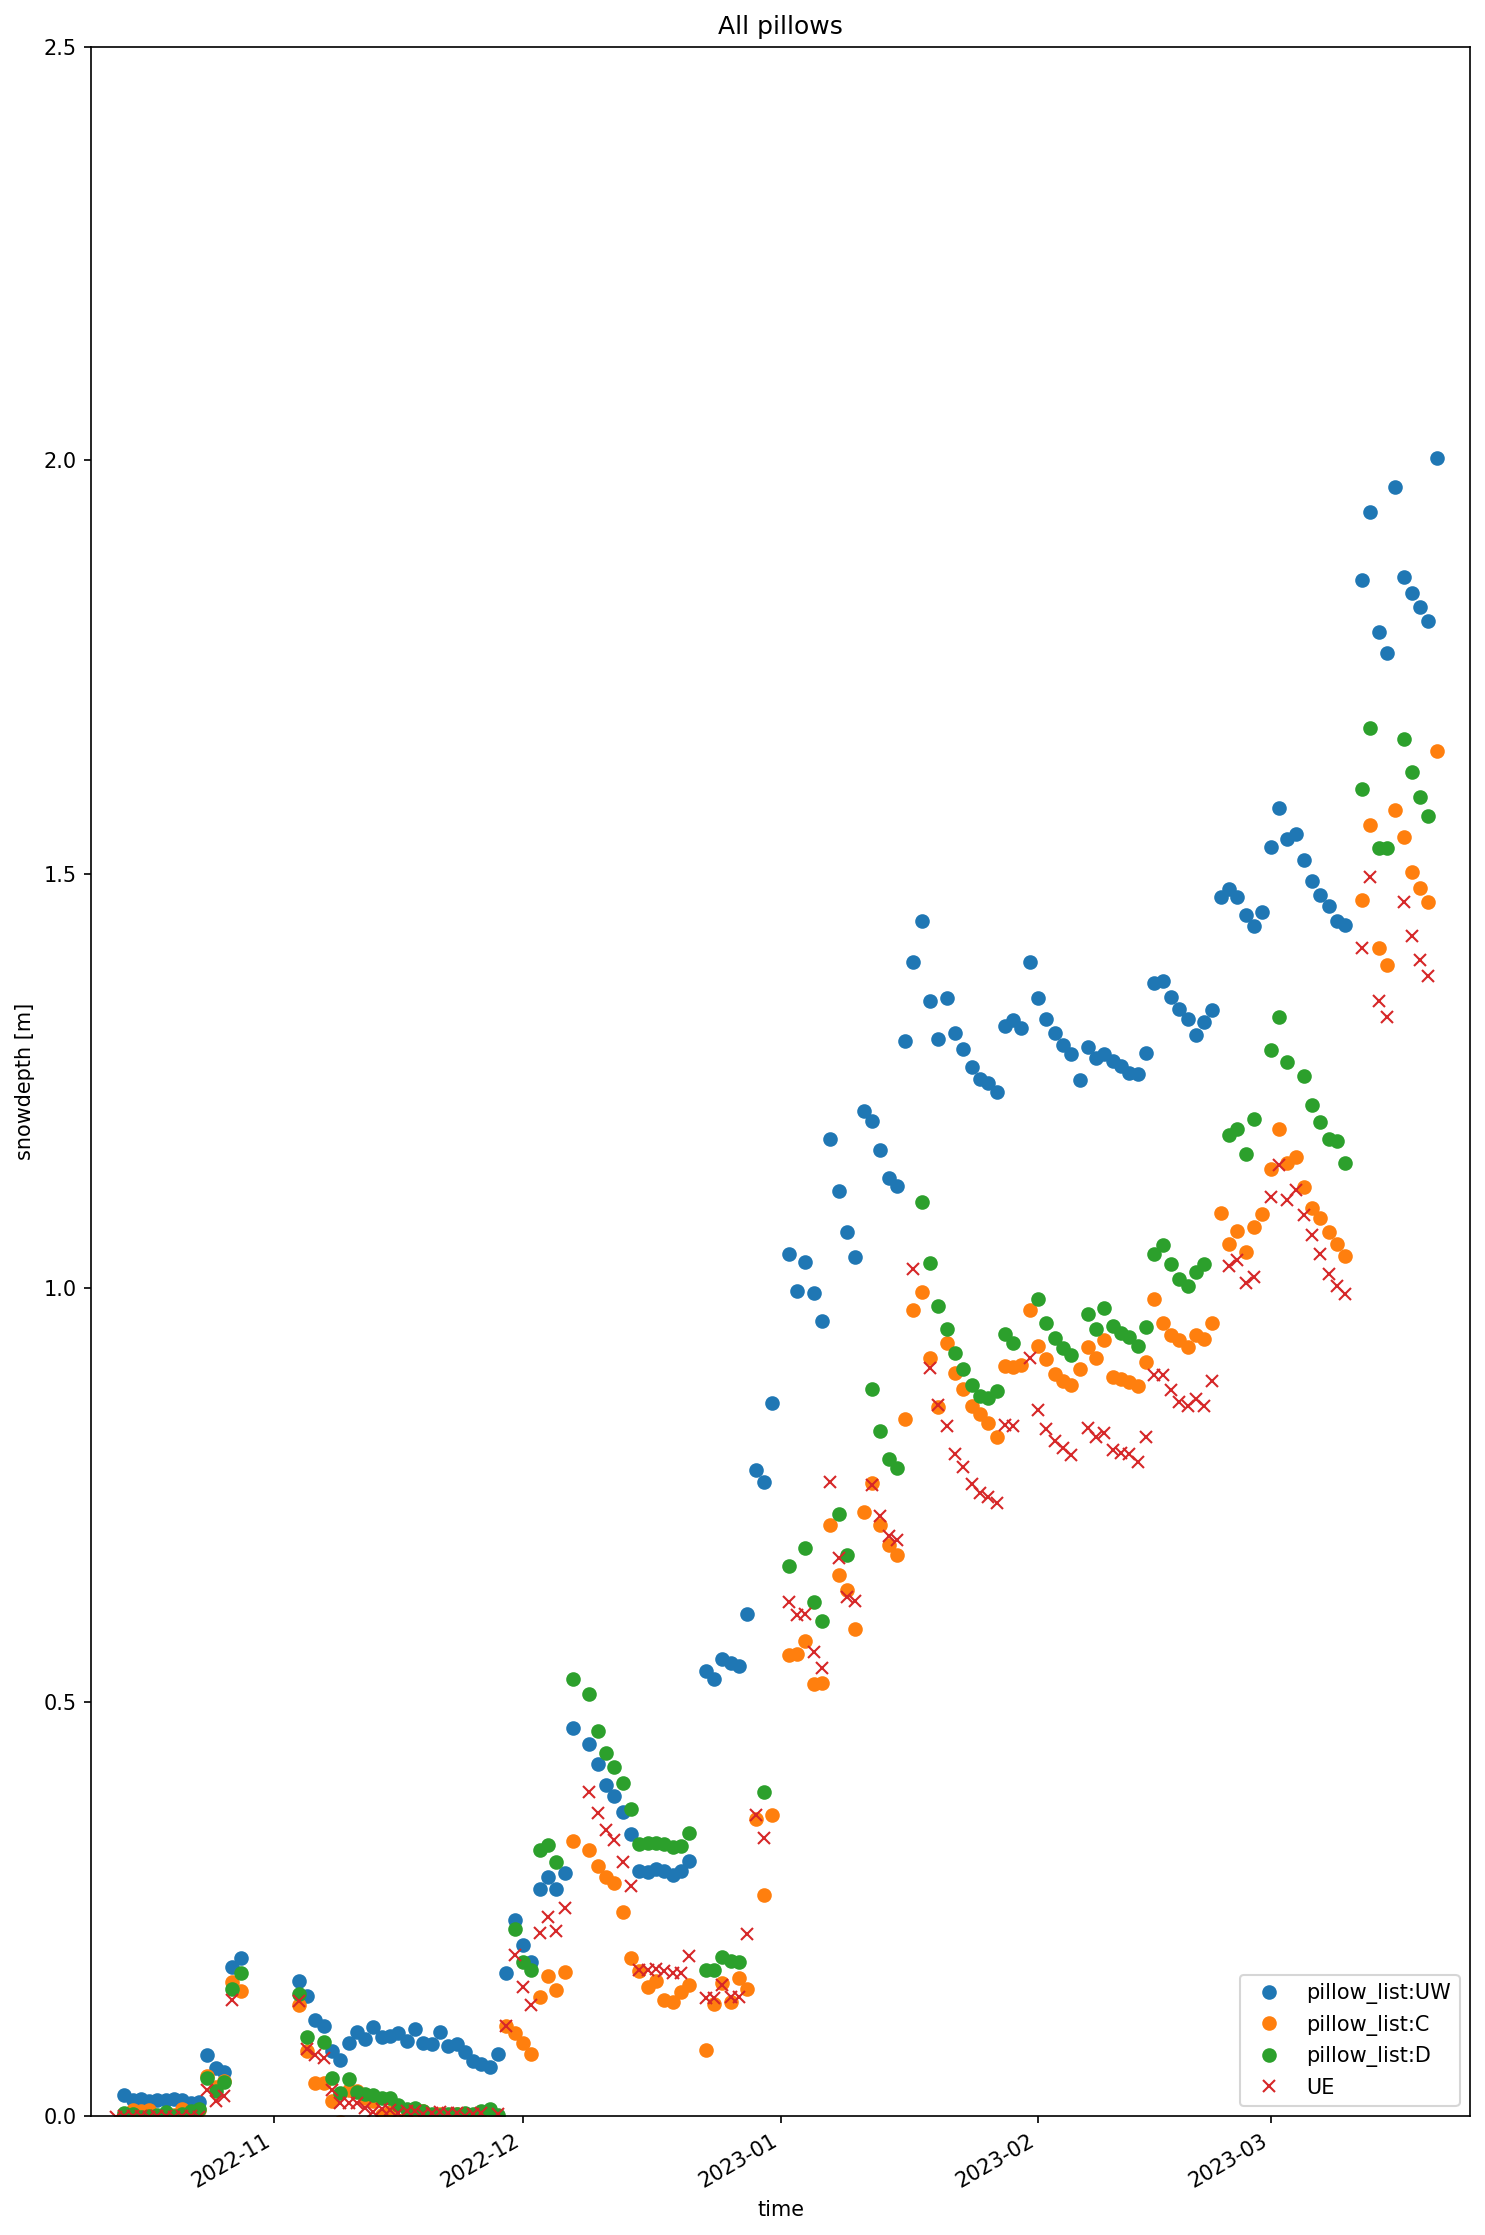

In [27]:
# Null hypothesis mean
plt.figure(figsize=(10,15), dpi=150)

colors = [f"C{i}" for i in range(6)]

# i represents a different lidar that is observing the snow depth

pillow_list = ["UW","C","D"]
# these designations indicate which snow pillow location we are measuring the depth at
# these locations, with labels, are indicated on the map shown in Module 2
# They stand for "UW = upwind west", "C = center", "UE = upwind east", and "D = downwind"

ci=0
for i,p in enumerate(pillow_list):
    l=6
    ci=0+1
    ds = xr.open_dataset(f"lidar_l{l}_pillow_depths.nc")
    
    try:
        if p in ds["pillow"]:
            s="median"
            ds["snowdepth"].sel(stat=s,pillow=p).plot(marker='o', linestyle="", label=f"pillow_list:{p}")                
    except:
        print(f"Error with lidar {l} for pillow {p}")

#And then we'll add in ds2 for UE that we investigated before 
ds2["snowdepth"].sel(stat=s,pillow="UE").plot(marker='x', linestyle="", label="UE")
plt.ylim(0,2.5)
plt.legend()
plt.title('All pillows')
plt.xlim(start_date, end_date)
    
plt.tight_layout()

From this plot, we notice that something different is happening to snow depth at the UW snow pillow in late November and again in late December.  Lab 3-2 will further investigate this in relation to the snow pillow data -- was it the same event?

From this plot, we also notice that after each event of snow depth going up, there's a subsequent event of snow dpeth going down.  This occurs at all of the pillow locations and is observed by all of the lidars.  